## Logistic Regression Model Comparisons - Lab

## Introduction

In this lab, you'll further investigate how to tune your own logistic regression implementation, as well as that of scikit-learn in order to produce better models.

## Objectives

- Compare the different inputs with logistic regression models and determine the optimal model 

In the previous lab, you were able to compare the output of your own implementation of the logistic regression model with that of scikit-learn. However, that model did not include an intercept or any regularization. In this investigative lab, you will analyze the impact of these two tuning parameters.

## Import the data

As with the previous lab, import the dataset stored in `'heart.csv'`: 

In [1]:
# Import the data
import pandas as pd
from IPython.core.display import HTML, Markdown

df = pd.read_csv('heart.csv')

# Print the first five rows of the data
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0.708333,1.0,1.000000,0.481132,0.244292,1.0,0.0,0.603053,0.0,0.370968,0.0,0.0,0.333333,1.0
1,0.166667,1.0,0.666667,0.339623,0.283105,0.0,0.5,0.885496,0.0,0.564516,0.0,0.0,0.666667,1.0
2,0.250000,0.0,0.333333,0.339623,0.178082,0.0,0.0,0.770992,0.0,0.225806,1.0,0.0,0.666667,1.0
3,0.562500,1.0,0.333333,0.245283,0.251142,0.0,0.5,0.816794,0.0,0.129032,1.0,0.0,0.666667,1.0
4,0.583333,0.0,0.000000,0.245283,0.520548,0.0,0.5,0.702290,1.0,0.096774,1.0,0.0,0.666667,1.0


## Split the data

Define `X` and `y` as with the previous lab. This time, follow best practices and also implement a standard train-test split. Assign 25% to the test set and set the `random_state` to 17. 

In [2]:
# Define X and y
y = df['target']
X = df.drop(columns=['target'], axis=1)

# Split the data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=17)
print(y_train.value_counts(),'\n\n', y_test.value_counts())

1.0    130
0.0     97
Name: target, dtype: int64 

 0.0    41
1.0    35
Name: target, dtype: int64


## Initial Model - Personal Implementation

Use your code from the previous lab to once again train a logistic regression algorithm on the training set.

In [3]:
# Your code from previous lab
import numpy as np

def sigmoid(X):
    return 1/(1 + np.e**(-X))

def prettify_cols_and_index(W_batch_history, X):
    W_batch_history.columns = np.arange(len(W_batch_history.columns))
    W_batch_history = W_batch_history.reset_index()
    W_batch_history['feat'] = list(X.columns)
    W_batch_history = W_batch_history.drop('index', axis=1)
    W_batch_history = W_batch_history.set_index('feat')
    return W_batch_history

def grad_desc(X, y, max_iterations, alpha, initial_weights=None, n_batch_history=None): # set n_batch_history to 5 or something reasonable to see genesis of weights up to that n-value
    """Be sure to set default behavior for the initial_weights parameter."""
    if initial_weights == None:
        initial_weights = np.ones((X.shape[1], 1)).flatten()
    W = initial_weights
    W_batch_history = pd.DataFrame(W) # this will be a |len(X)| x |iterations+1| matrix - i.e. there are len(X) (num predictors) rows and iterations+1 columns; it is batch since each row grows in length (num cols) with each iteration; this is precisely because we transpose X (below)

    if n_batch_history is not None:
        W_batch_history = prettify_cols_and_index(W_batch_history, X)
        display(HTML(f"<h3>First few tables of Weight batch-history:</h3>"))

    # Create a for loop of iterations
    for iter in range(max_iterations):
        # Generate predictions using the current feature weights
        y_hat = sigmoid(X.dot(W))

        # Calculate an error vector based on these initial predictions and the correct labels
        E = y - y_hat

        # Calculate the gradient 
        # As we saw in the previous lab, calculating the gradient is often the most difficult task.
        # Here, your are provided with the closed form solution for the gradient of the log-loss function derived from MLE
        # For more details on the derivation, see the additional resources section below.
        gradient = np.dot(X.transpose(), E)

        # Update the weight vector take a step of alpha in direction of gradient 
        W += alpha * gradient   # the weight vector becomes
        if n_batch_history is not None and iter < n_batch_history:
            W_batch_history = prettify_cols_and_index(pd.concat([W_batch_history.reset_index().drop('feat', axis=1), pd.DataFrame(W)], axis=1), X)
            display(HTML(f"<h4>Iteration {iter+1}:</h4>"))
            display(HTML(W_batch_history.to_html()))
        else:
            W_batch_history = pd.concat([W_batch_history, pd.DataFrame(W)], axis=1)
            W_batch_history.columns = np.arange(len(W_batch_history.columns))

    print(f"Final weights: {W}")
    if n_batch_history is None:
        prettify_cols_and_index(W_batch_history, X)
    print(f"Final Weight batch-history shape: {W_batch_history.shape}")

    # Return finalized weights
    return (W, W_batch_history)

In [4]:
W, W_batch_history = grad_desc(X_train, y_train, 50000, 0.001)

Final weights: [ 0.77803589 -2.17904675  2.60297636 -2.64293402 -2.41063551  0.02614971
  1.35662453  6.73467316 -1.10155543 -3.92267119  0.71334478 -3.38851215
 -1.78113387]
Final Weight batch-history shape: (13, 50001)


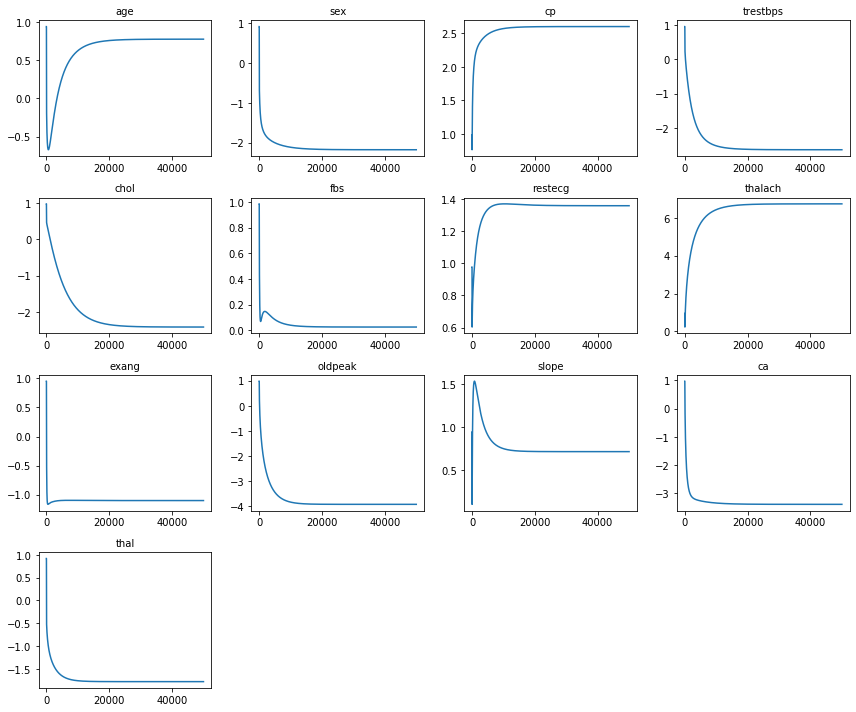

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(12,10))
for (i, j) in enumerate(W):
    plt.subplot(4, 4, i+1)
    plt.title(list(X_train)[i], size='medium')
    plt.plot(W_batch_history.iloc[i].T)
    plt.axis('tight')
fig.tight_layout()
plt.show()

## Make [probability] predictions on the test set

In [6]:
# Predict on test set
y_hat_test = sigmoid(X_test.dot(W))
np.round(y_hat_test, 2)

182    0.96
226    0.02
176    0.09
207    0.12
221    0.00
       ... 
239    0.18
48     0.98
274    0.02
3      0.96
136    0.94
Length: 76, dtype: float64

## Create an ROC curve for your predictions

AUC: 0.8996515679442508


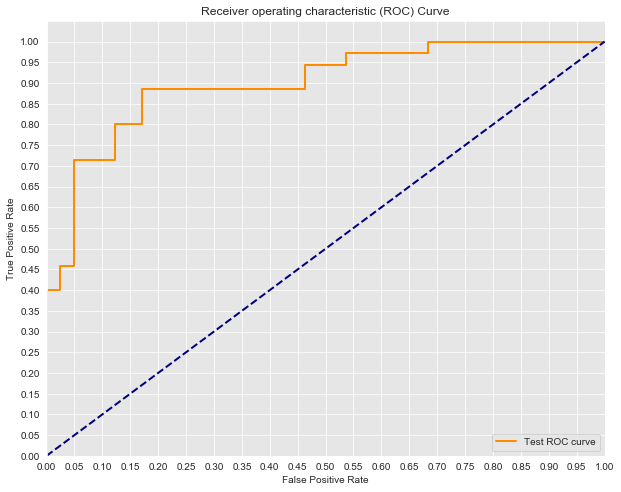

In [7]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_hat_test)

print('AUC: {}'.format(auc(test_fpr, test_tpr)))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

plt.figure(figsize=(10, 8))
lw = 2

plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Test ROC curve')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Update your ROC curve to include the training set

Train AUC: 0.9291038858049168
AUC: 0.8996515679442508


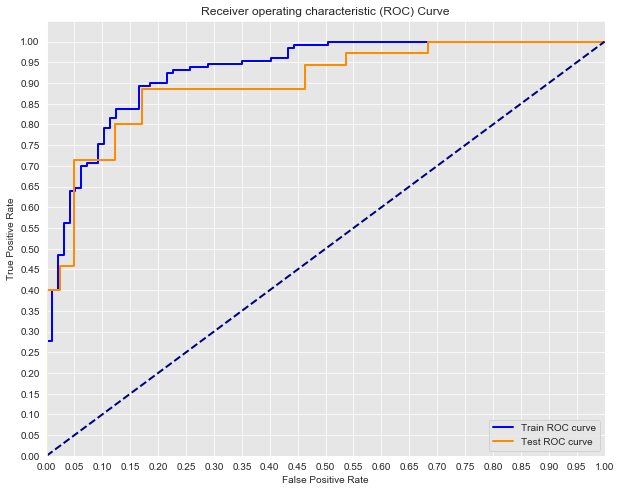

In [8]:
y_hat_train = sigmoid(X_train.dot(W))

train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_hat_train)

test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_hat_test)

# Train AUC
print('Train AUC: {}'.format(auc(train_fpr, train_tpr)))
print('AUC: {}'.format(auc(test_fpr, test_tpr)))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

plt.figure(figsize=(10, 8))
lw = 2

plt.plot(train_fpr, train_tpr, color='blue',
         lw=lw, label='Train ROC curve')
plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Test ROC curve')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Create a confusion matrix for your predictions

Use a standard decision boundary of 0.5 to convert your probabilities output by logistic regression into binary classifications. (Again this should be for the test set.) Afterward, feel free to use the built-in scikit-learn function to compute the confusion matrix as we discussed in previous sections.

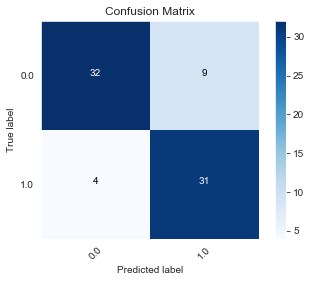

In [9]:
# Your code here
from sklearn.metrics import confusion_matrix
import itertools

cnf_matrix = confusion_matrix(y_test, (y_hat_test >= 0.5).astype('int')) # don't forget! 1st param is y true, second is y_hat

# Create the basic matrix
plt.imshow(cnf_matrix, cmap=plt.cm.Blues) 

# Add title and axis labels
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add appropriate axis scales
class_names = set(y) # Get class labels to add to matrix
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add labels to each cell
thresh = cnf_matrix.max() / 2. # Used for text coloring below
# Here we iterate through the confusion matrix and append labels to our visualization 
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(
        j, 
        i, 
        cnf_matrix[i, j],
        horizontalalignment='center',
        color='white' if cnf_matrix[i, j] > thresh else 'black'
    )

# Add a legend
plt.colorbar()
plt.grid(False)
plt.show()

## Initial Model - scikit-learn

Use scikit-learn to build a similar model. To start, create an identical model as you did in the last section; turn off the intercept and set the regularization parameter, `C`, to a ridiculously large number such as 1e16. 

In [10]:
# Your code here
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(fit_intercept=False, C=1e16, solver='liblinear')
logreg.fit(X_train, y_train)

LogisticRegression(C=1e+16, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

## Create an ROC Curve for the scikit-learn model

Use both the training and test sets

Train AUC: 0.9291038858049168
Test AUC: 0.8996515679442508


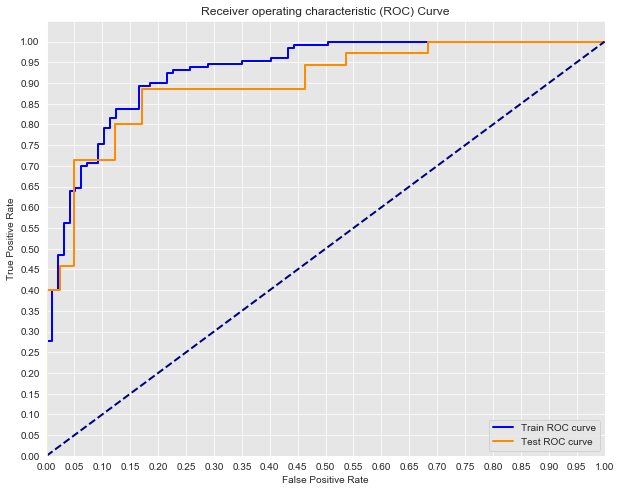

In [11]:
# Your code here

y_train_score = logreg.decision_function(X_train)
y_test_score = logreg.decision_function(X_test)

train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_score)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)


print('Train AUC: {}'.format(auc(train_fpr, train_tpr)))
print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))

plt.figure(figsize=(10, 8))
lw = 2

plt.plot(train_fpr, train_tpr, color='blue',
         lw=lw, label='Train ROC curve')
plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Test ROC curve')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Add an Intercept

Now add an intercept to the scikit-learn model. Keep the regularization parameter `C` set to a very large number such as 1e16. 

In [12]:
# Create new model
logregi = LogisticRegression(fit_intercept=True, C=1e16, solver='liblinear')
logregi.fit(X_train, y_train)

LogisticRegression(C=1e+16, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Plot all three models ROC curves on the same graph.

Custom Model Test AUC: 0.8996515679442508
Custome Model Train AUC: 0.9291038858049168
Scikit-learn Model 1 Test AUC: 0.8996515679442508
Scikit-learn Model 1 Train AUC: 0.9291038858049168
Scikit-learn Model 2 with intercept Test AUC: 0.8989547038327527
Scikit-learn Model 2 with intercept Train AUC: 0.9325931800158604


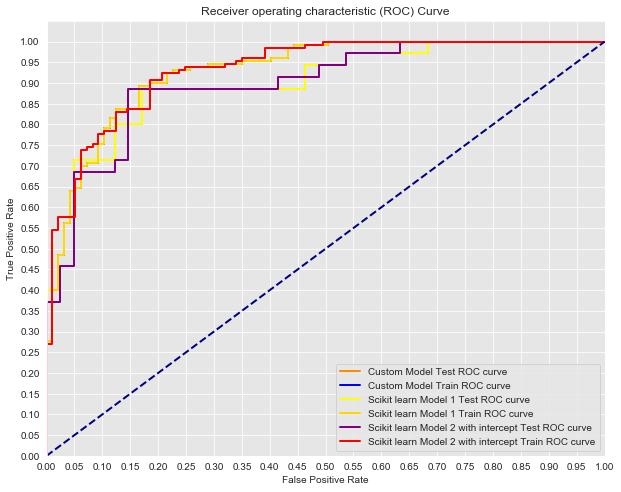

In [13]:
# Initial model plots
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_hat_test)
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_hat_train)


print('Custom Model Test AUC: {}'.format(auc(test_fpr, test_tpr)))
print('Custome Model Train AUC: {}'.format(auc(train_fpr, train_tpr)))

plt.figure(figsize=(10,8))
lw = 2

plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Custom Model Test ROC curve')
plt.plot(train_fpr, train_tpr, color='blue',
         lw=lw, label='Custom Model Train ROC curve')


# Second model plots
y_test_score = logreg.decision_function(X_test)
y_train_score = logreg.decision_function(X_train)

test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_score)

print('Scikit-learn Model 1 Test AUC: {}'.format(auc(test_fpr, test_tpr)))
print('Scikit-learn Model 1 Train AUC: {}'.format(auc(train_fpr, train_tpr)))


plt.plot(test_fpr, test_tpr, color='yellow',
         lw=lw, label='Scikit learn Model 1 Test ROC curve')
plt.plot(train_fpr, train_tpr, color='gold',
         lw=lw, label='Scikit learn Model 1 Train ROC curve')


# Third model plots
y_test_score = logregi.decision_function(X_test)
y_train_score = logregi.decision_function(X_train)

test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_score)

print('Scikit-learn Model 2 with intercept Test AUC: {}'.format(auc(test_fpr, test_tpr)))
print('Scikit-learn Model 2 with intercept Train AUC: {}'.format(auc(train_fpr, train_tpr)))


plt.plot(test_fpr, test_tpr, color='purple',
         lw=lw, label='Scikit learn Model 2 with intercept Test ROC curve')
plt.plot(train_fpr, train_tpr, color='red',
         lw=lw, label='Scikit learn Model 2 with intercept Train ROC curve')

# Formatting
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Altering the Regularization Parameter

Now, experiment with altering the regularization parameter. At a minimum, create 5 different subplots with varying regularization (`C`) parameters. For each, plot the ROC curve of the training and test set for that specific model.  

Regularization parameters between 1 and 20 are recommended. Observe the difference in test and training AUC as you go along.

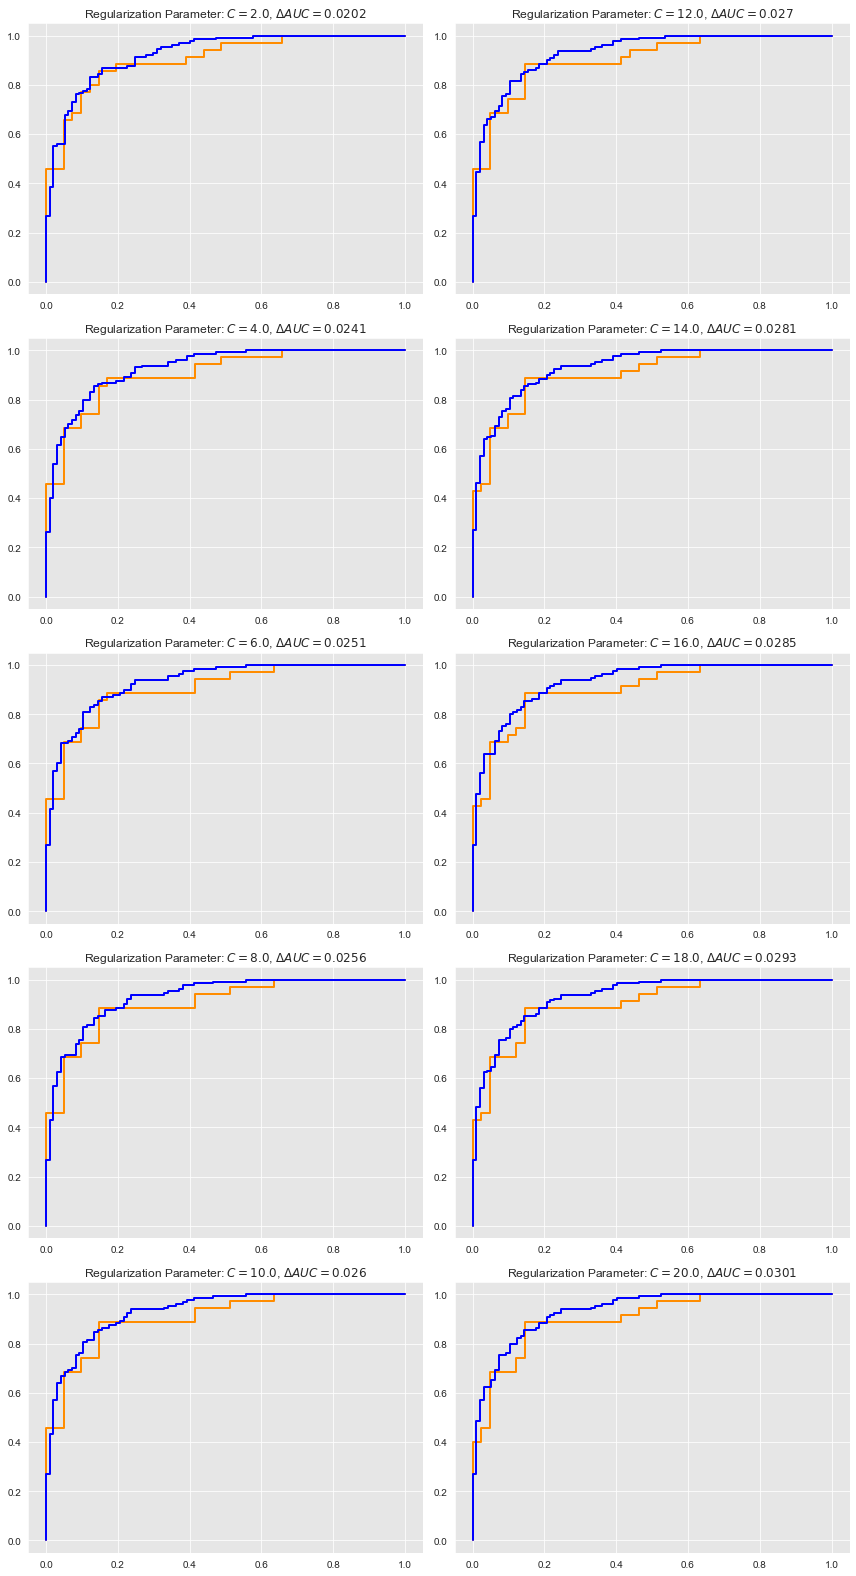

In [14]:
# Your code here
n_plots = 10
n_cols = 2
n_rows = n_plots//n_cols
C_ub = 20

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12,22))
for n in range(n_plots):
    i = n % n_rows
    j = n//n_rows
    ax = axes[i, j]

    # Fit a model
    C = (C_ub/n_plots)*(n+1)
    logreg = LogisticRegression(fit_intercept=True, C=C, solver='liblinear')
    logreg.fit(X_train, y_train)
    
    y_test_score = logreg.decision_function(X_test)
    y_train_score = logreg.decision_function(X_train)

    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)
    train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_score)
    
    test_auc = auc(test_fpr, test_tpr)
    train_auc = auc(train_fpr, train_tpr)
    auc_diff = round(train_auc - test_auc, 4)

    # Add the plot
    ax.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Test ROC curve')
    ax.plot(train_fpr, train_tpr, color='blue',
             lw=lw, label='Train ROC curve')
    
    ax.set_title(f"Regularization Parameter: $C={round(C,4)}$, $\\Delta AUC={auc_diff}$")

fig.tight_layout()
plt.show()

How did the regularization parameter impact the ROC curves plotted above? 

In [15]:
# delta AUC is monotonically increasing

## Summary

In this lab, you reviewed many of the accuracy measures for classification algorithms and observed the impact of additional tuning models using intercepts and regularization.